In [1]:
import os
import time
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision.transforms as T
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.models import resnet50, ResNet50_Weights
from collections import OrderedDict
import matplotlib.pyplot as plt
import zipfile
from torchvision.io import read_image
from PIL import Image
import math
import random
from torch.nn.utils.rnn import pad_sequence
from torchvision.utils import draw_keypoints
from torchvision.io import read_image
import torchvision.transforms.functional as F
import torch.quantization

#heyhey

# from utils import *


# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")


In [2]:
weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
k_transforms = weights.transforms()
keypoint_rcnn = keypointrcnn_resnet50_fpn(weights=weights, progress=False, num_classes=2)
keypoint_rcnn.eval()

quantized_krcnn = torch.quantization.quantize_dynamic(keypoint_rcnn, {torch.nn.Linear}, dtype=torch.qint8)


In [3]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

70
49 21
fall-02-cam0-rgb-037.png
torch.Size([3, 90, 90])


/usr/local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


3.5396857261657715
torch.Size([5, 17, 3])
fall-02-cam0-rgb-073.png
torch.Size([3, 90, 90])
3.4967079162597656
torch.Size([6, 17, 3])
fall-02-cam0-rgb-109.png
torch.Size([3, 90, 90])
3.397186756134033
torch.Size([6, 17, 3])
torch.Size([9, 90, 90])


{'img_list': tensor([[[181, 173, 165,  ..., 254, 254, 253],
          [189, 180, 171,  ..., 254, 254, 252],
          [197, 190, 178,  ..., 254, 254, 254],
          ...,
          [ 31,  32,  37,  ...,  74,  73,  65],
          [ 33,  30,  32,  ...,  73,  75,  68],
          [ 35,  39,  37,  ...,  69,  73,  70]],
 
         [[162, 153, 144,  ..., 254, 254, 253],
          [169, 158, 150,  ..., 254, 254, 252],
          [180, 167, 156,  ..., 254, 254, 254],
          ...,
          [ 35,  37,  41,  ...,  84,  84,  77],
          [ 37,  38,  40,  ...,  86,  85,  77],
          [ 41,  43,  44,  ...,  84,  84,  82]],
 
         [[166, 154, 143,  ..., 254, 254, 251],
          [175, 161, 150,  ..., 254, 254, 250],
          [186, 173, 158,  ..., 254, 254, 252],
          ...,
          [ 36,  40,  41,  ...,  83,  78,  73],
          [ 38,  40,  41,  ...,  83,  77,  72],
          [ 41,  46,  50,  ...,  84,  78,  78]],
 
         ...,
 
         [[181, 173, 165,  ..., 254, 254, 255],
      

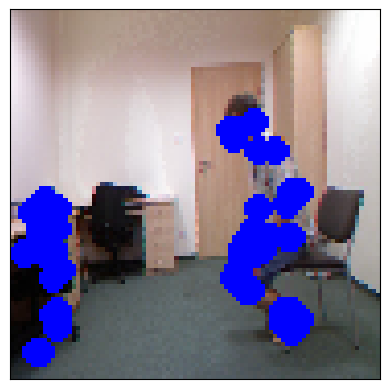

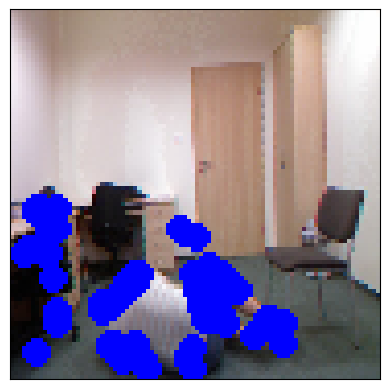

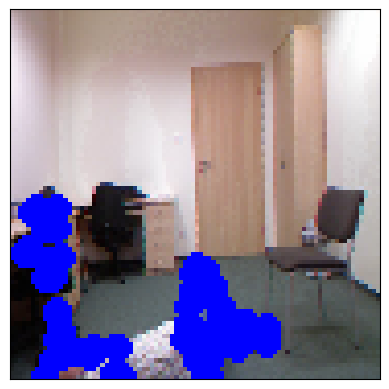

In [4]:

class URFallDataset(Dataset):
    """ a sample of the dataset will be a selection of frames and name of zipfile"""
    
    def __init__(self, root_dir, folders, transform=None, sampling=False, sample_len=50):
        self.root_dir = root_dir
        self.transform = transform
        self.sequences = folders
        self.sampling = sampling
        self.sample_len = sample_len

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        png_list = []
        keypoint_list = []

        path_name = os.path.join(self.root_dir, self.sequences[idx])
        inf_list = os.listdir(path_name)
        inf_list.sort()
        #print(inf_list)

        if self.sampling: #indexing not great
            interval = len(inf_list) // self.sample_len
            #print(self.sequences[idx], "total", len(inf_list), "interval", interval)
            start = len(inf_list) - interval * self.sample_len
            for i in range(start, len(inf_list)):
                if i % interval == 0:
                    png = Image.open(path_name + "/" + inf_list[i])
                    print(inf_list[i])
                    png_t = self.transform(png)
                    png_list += [self.transform(png)]

                    t = transforms.Compose([transforms.PILToTensor(), 
                                transforms.Resize(size=[img_size,img_size]), k_transforms])
                    print((t(png)).shape)
                    start = time.time()
                    outputs = quantized_krcnn([t(png)])
                    print(time.time()-start)
                    keypoints = outputs[0]['keypoints']
                    print(keypoints.shape)
                    keypoint_list += [keypoints]


                    res = draw_keypoints(png_t, keypoints, colors="blue", radius=3)
                    show(res)

        #print("png len", len(png_list))
        print(torch.cat(png_list, 0).shape)

        # "fall" or "adl-"
        fall_b = [1, 0] if self.sequences[idx][:4] == 'fall' else [0, 1]
        sample = {"img_list": torch.cat(png_list, 0), "category": torch.tensor(fall_b)}
        return sample

root_dir="/Users/dy/Documents/ODML/urf-rgb"
folders = os.listdir(root_dir)
if ".DS_Store" in folders:
    folders.remove(".DS_Store")
random.shuffle(folders)
print(len(folders))
train_size = int(len(folders)*0.7)

train_seq = folders[:train_size]
test_seq = folders[train_size:]

img_size=90
sample_len=3
transform = transforms.Compose([transforms.PILToTensor(), 
                                transforms.Resize(size=[img_size,img_size])])

urf_train = URFallDataset(root_dir, folders = train_seq, transform=transform, sampling=True, sample_len=sample_len)
urf_test = URFallDataset(root_dir, folders = test_seq, transform=transform, sampling=True, sample_len=sample_len)

train_dataloader = DataLoader(urf_train, batch_size=1, shuffle=True, num_workers=0)
test_dataloader = DataLoader(urf_test, batch_size=1, shuffle=True, num_workers=0)

print(len(urf_train), len(urf_test))

next(iter(urf_test))
# total_pos = 0
# for i, sample in list(enumerate(urf_test))[0]:
#     if torch.eq(sample["category"], torch.tensor([1,0]))[0]:
#         total_pos += 1
#     print("sampling", i)
# print(total_pos, len(test_seq), "fall rate in test dset", total_pos/len(test_seq))


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, size, numLayer=1, numNeuron=[1024]):
        super().__init__()
        self.flatten = nn.Flatten()
        
        self.layers = OrderedDict()
        self.layers['0'] = nn.Linear(size, numNeuron[0])
        self.layers['1'] = nn.ReLU()
        #hidden_layers(self.layers, numLayer, numNeuron)
        for i in range(numLayer-1):
            self.layers[str(2*i+2)] = nn.Linear(numNeuron[i], numNeuron[i+1])
            self.layers[str(2*i+3)] = nn.ReLU()
        self.layers['z'] = nn.Linear(numNeuron[-1], 2)

        self.linear_relu_stack = nn.Sequential(self.layers)


    def forward(self, x):
        print('imagetensor: {}'.format(x.shape))
        x = self.flatten(x)
        # x = x.to(torch.float64)
        logits = self.linear_relu_stack(x)
        return logits


In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, sample in enumerate(dataloader): #?
        target = sample['category']
        img = sample['img_list']
        # print(target, img)
        print("batch", batch)
        # print("istensorimg", torch.is_tensor(img))
        # print("img tensor shape", img.shape, "target shape", target.shape)
        img = img.to(torch.float32)
        # print(img)
        pred = model(img)
        pred_probab = nn.Softmax(dim=1)(pred)
        # print("pred", pred_probab, pred)
        loss = loss_fn(pred_probab, target.to(torch.float16))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(img)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, tp, correct = 0, 0, 0
    false_negative = 0
    predicted_pos = 0

    def is_fall(a):
        return torch.argmax(pred) == 0

    with torch.no_grad():
        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        for sample in dataloader:
            img = sample['img_list']
            target = sample['category']
            img = img.to(torch.float32)
            pred = model(img)
            pred_probab = nn.Softmax(dim=1)(pred)
            print("pred", pred, pred_probab, torch.argmax(pred))

            test_loss += loss_fn(pred_probab, target.to(torch.float16)).item()
            tp += 1 if is_fall(pred_probab) and is_fall(target) else 0
            correct += 1 if is_fall(pred_probab) == is_fall(target) else 0
            #(torch.argmax(pred, 1) == target).type(torch.float).sum().item() 
            predicted_pos += 1 if is_fall(pred_probab) else 0
            false_negative += 1 if not is_fall(pred_probab) and is_fall(target) else 0

    test_loss /= num_batches
    accuracy = correct / size
    precision = tp/predicted_pos if predicted_pos > 0 else 0
    recall = tp/(tp+false_negative) if tp > 0  else 0
    f1 = 2*precision*recall/(precision+recall) if tp > 0  else 0
    print(f"Test Error: \n Accuracy: {(100*tp/size):>0.1f}%, Avg loss: {test_loss:>8f}, Recall: {(100*recall):>0.1f}%, F1: {(100*f1):>0.1f}% \n")
    return accuracy, recall, f1

In [8]:
device = ("cpu")
keypoint_rcnn = get_Krcnn()

root_dir="/Users/dy/Documents/ODML/urf-rgb"
folders = os.listdir(root_dir)
if ".DS_Store" in folders:
    folders.remove(".DS_Store")
random.shuffle(folders)
print(len(folders))
train_size = int(len(folders)*0.7)

train_seq = folders[:train_size]
test_seq = folders[train_size:]


sample_len_l = [1,3,5,7,9]
img_size_l = [1,5,10,20,40]
layerList = [1,2,3,4,5]
neuronList = [[100],[200,200],[300,300,300],[400,400,400,400],[500,500,500,500,500]]

flops = []
accuracys = []
recalls = []
f1s = []
latency = []

for i in range(len(sample_len_l)):
    sample_len = sample_len_l[i]
    img_size = img_size_l[i]

    transform = transforms.Compose([transforms.PILToTensor(), 
                                    transforms.Resize(size=[img_size,img_size])])

    urf_train = URFallDataset(root_dir, folders = train_seq, transform=transform, sampling=True, sample_len=sample_len)
    urf_test = URFallDataset(root_dir, folders = test_seq, transform=transform, sampling=True, sample_len=sample_len)

    train_dataloader = DataLoader(urf_train, batch_size=1, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(urf_test, batch_size=1, shuffle=True, num_workers=0)

    print(len(urf_train), len(urf_test))

    total_pos = 0
    for i, sample in list(enumerate(urf_test)):
        if torch.eq(sample["category"], torch.tensor([1,0]))[0]:
            total_pos += 1
        print("sampling", i)
    print(total_pos, len(test_seq), "fall rate in test dset", total_pos/len(test_seq))


    numL = layerList[i]
    numN = neuronList[i]

    size = sample_len * img_size * img_size * 3 
    print(size)

    model = NeuralNetwork(size=size, numLayer=numL, numNeuron=numN).to(device)
    print(model)
    print("param count", parameter_count(model))
    print("model flop count", flop_count(model))

    learning_rate = 1e-3
    epochs = 2

    # Initialize the loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        start_t = time.time()
        train_loop(train_dataloader, model, loss_fn, optimizer)
        print("training used", time.time() - start_t, "s")
        
        start_t = time.time()
        (accuracy, recall, f1) = test_loop(test_dataloader, model, loss_fn)
        print("inference latency", (time.time() - start_t) * 1000 / len(urf_test), "ms")

        #calculate metrics ##
        flops += [flop_count(model)]
        accuracys += [accuracy]
        recalls += [recall]
        f1s += [f1]
        latency += [(time.time() - start_t)/10]

    print(sample_len, img_size)
    print("flops=", flops, "\n", "accuracy, recall, f1=", accuracys, recalls, f1s, "\n", "latency=", latency)


NameError: name 'get_Krcnn' is not defined

In [ ]:
flops = []
accuracys = []
recalls = []
f1s = []
latency = []

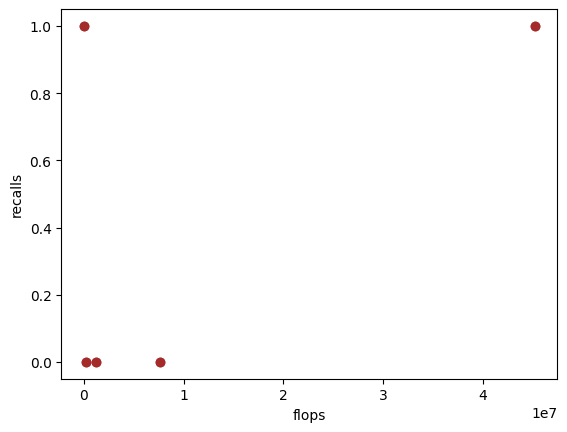

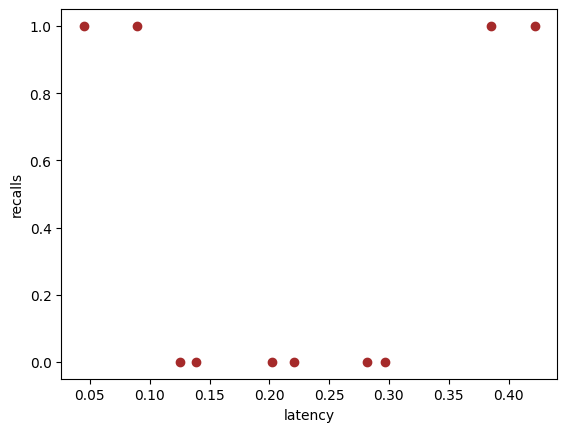

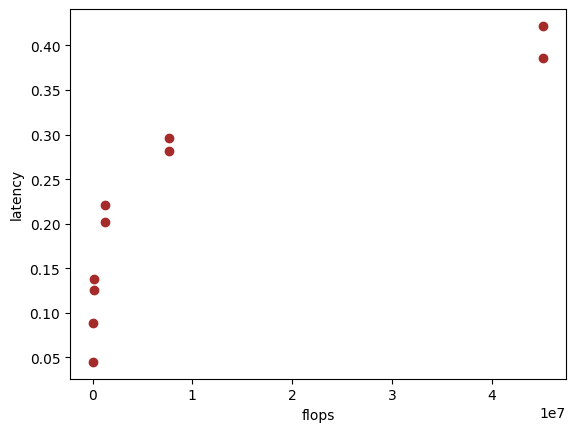

In [ ]:
def show_graph_image(sizes, accuracy, latency, a, b, c, color):

    plt.xlabel(a)
    plt.ylabel(b)
    plt.scatter(sizes, accuracy, color = color)

    plt.show()

    plt.xlabel(c)
    plt.ylabel(b)
    plt.scatter(latency, accuracy, color = color)

    plt.show()

    plt.xlabel(a)
    plt.ylabel(c)
    plt.scatter(sizes, latency, color = color)

    plt.show()

show_graph_image(flops, recalls, latency, "flops", 'recalls', 'latency', "brown")